In [1]:
import pandas as pd
import numpy as np
import csv as csv
import os
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

import pyspark.sql.functions as F
from pyspark.ml.feature import VectorAssembler

%matplotlib inline

In [2]:
# Data cleanup
# TRAIN DATA
os.chdir(os.path.expanduser("~/Dropbox/Projects/data/kaggle/allstate_claims_severity/"))
train = pd.read_csv('train.csv', header=0)        # Load the train file into a dataframe
test = pd.read_csv('test.csv', header=0)
train.head()

,id,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,...,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,cont14,loss
0,1,A,B,A,B,A,A,A,A,B,...,0.718367,0.335060,0.30260,0.67135,0.83510,0.569745,0.594646,0.822493,0.714843,2213.18
1,2,A,B,A,A,A,A,A,A,B,...,0.438917,0.436585,0.60087,0.35127,0.43919,0.338312,0.366307,0.611431,0.304496,1283.60
2,5,A,B,A,A,B,A,A,A,B,...,0.289648,0.315545,0.27320,0.26076,0.32446,0.381398,0.373424,0.195709,0.774425,3005.09
3,10,B,B,A,B,A,A,A,A,B,...,0.440945,0.391128,0.31796,0.32128,0.44467,0.327915,0.321570,0.605077,0.602642,939.85
4,11,A,B,A,B,A,A,A,A,B,...,0.178193,0.247408,0.24564,0.22089,0.21230,0.204687,0.202213,0.246011,0.432606,2763.85


In [3]:
train.columns.values
cat = ['cat1', 'cat2', 'cat3', 'cat4', 'cat5', 'cat6', 'cat7',
       'cat8', 'cat9', 'cat10', 'cat11', 'cat12', 'cat13', 'cat14',
       'cat15', 'cat16', 'cat17', 'cat18', 'cat19', 'cat20', 'cat21',
       'cat22', 'cat23', 'cat24', 'cat25', 'cat26', 'cat27', 'cat28',
       'cat29', 'cat30', 'cat31', 'cat32', 'cat33', 'cat34', 'cat35',
       'cat36', 'cat37', 'cat38', 'cat39', 'cat40', 'cat41', 'cat42',
       'cat43', 'cat44', 'cat45', 'cat46', 'cat47', 'cat48', 'cat49',
       'cat50', 'cat51', 'cat52', 'cat53', 'cat54', 'cat55', 'cat56',
       'cat57', 'cat58', 'cat59', 'cat60', 'cat61', 'cat62', 'cat63',
       'cat64', 'cat65', 'cat66', 'cat67', 'cat68', 'cat69', 'cat70',
       'cat71', 'cat72', 'cat73', 'cat74', 'cat75', 'cat76', 'cat77',
       'cat78', 'cat79', 'cat80', 'cat81', 'cat82', 'cat83', 'cat84',
       'cat85', 'cat86', 'cat87', 'cat88', 'cat89', 'cat90', 'cat91',
       'cat92', 'cat93', 'cat94', 'cat95', 'cat96', 'cat97', 'cat98',
       'cat99', 'cat100', 'cat101', 'cat102', 'cat103', 'cat104', 'cat105',
       'cat106', 'cat107', 'cat108', 'cat109', 'cat110', 'cat111',
       'cat112', 'cat113', 'cat114', 'cat115', 'cat116']

con = ['cont1', 'cont2',
       'cont3', 'cont4', 'cont5', 'cont6', 'cont7', 'cont8', 'cont9',
       'cont10', 'cont11', 'cont12', 'cont13', 'cont14']
# for v in cat:
#     print v
#     print train[v].value_counts()

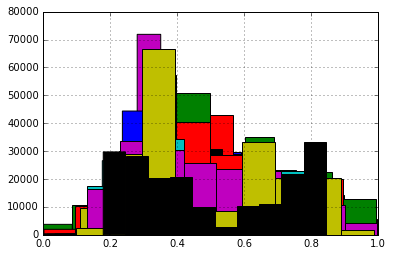

In [8]:
for c in con:
    train[c].hist()

In [4]:
le = LabelEncoder()
for v in cat:
    le.fit(train[v].append(test[v], ignore_index=True))
#     print list(le.classes_)
    train[v] = le.transform(train[v])
    test[v] = le.transform(test[v])
# train.head()

In [5]:
enc = OneHotEncoder()

enc.fit(train[cat].append(test[cat], ignore_index=True))
train_cat = enc.transform(train[cat]).toarray()
test_cat = enc.transform(test[cat]).toarray()

In [6]:
train_con = train[con]
test_con = test[con]
# train_con

In [7]:
from sklearn.preprocessing import Imputer
imp = Imputer(missing_values='NaN', strategy='mean', axis=0)
imp.fit(train_con)
train_con = imp.transform(train_con) 
test_con = imp.transform(test_con) 

In [8]:
X_train = np.concatenate((train_cat, train_con), axis=1)
X_test = np.concatenate((test_cat, test_con), axis=1)
Y_train = train.loss

In [ ]:
spark.createDataFrame(pd.DataFrame(X_train)).show()

In [11]:
ids = test['id'].values

In [13]:
from sklearn.ensemble import RandomForestRegressor

print 'Training...'
forest = RandomForestRegressor(max_depth=30, random_state=2).fit(X_train, Y_train)

print 'Predicting...'
output = forest.predict(X_test)

predictions_file = open("submissions/forest0.csv", "wb")
open_file_object = csv.writer(predictions_file)
open_file_object.writerow(["id","loss"])
open_file_object.writerows(zip(ids, output))
predictions_file.close()
print 'Done.'

Training...
Predicting...
Done.


In [17]:
from sklearn.linear_model import LassoCV

print 'Training...'
lasso = LassoCV().fit(X_train, Y_train)

print 'Predicting...'
output = lasso.predict(X_test)

predictions_file = open("submissions/lasso0.csv", "wb")
open_file_object = csv.writer(predictions_file)
open_file_object.writerow(["id","loss"])
open_file_object.writerows(zip(ids, output))
predictions_file.close()
print 'Done.'

Training...
Predicting...
Done.


In [19]:
from sklearn.linear_model import RidgeCV

print 'Training...'
ridge = RidgeCV(alphas=[0.1, 0.5, 1.0, 3.0]).fit(X_train, Y_train)

print 'Predicting...'
output = ridge.predict(X_test)

predictions_file = open("submissions/ridge0.csv", "wb")
open_file_object = csv.writer(predictions_file)
open_file_object.writerow(["id","loss"])
open_file_object.writerows(zip(ids, output))
predictions_file.close()
print 'Done.'

Training...
Predicting...
Done.


In [21]:
train.shape

(188318, 132)

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor

# use a full grid over all parameters
param_grid = {'learning_rate': [0.08, 0.1, 0.12], 
              'max_depth': [1, 2, 3, 4], 
              'loss': ['ls', 'lad', 'huber']
             }

est = GradientBoostingRegressor(n_estimators=200, random_state=0)
# run grid search
grid_search = GridSearchCV(est, param_grid=param_grid).fit(X_train, Y_train)

print 'Predicting...'
output = grid_search.predict(X_test)

predictions_file = open("submissions/gr0.csv", "wb")
open_file_object = csv.writer(predictions_file)
open_file_object.writerow(["id","loss"])
open_file_object.writerows(zip(ids, output))
predictions_file.close()
print 'Done.'

In [23]:
print 'Training...'
est = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, 
                                            max_depth=1, random_state=0, loss='ls').fit(X_train, Y_train)
print 'Predicting...'
output = est.predict(X_test)

predictions_file = open("submissions/gbm0.csv", "wb")
open_file_object = csv.writer(predictions_file)
open_file_object.writerow(["id","loss"])
open_file_object.writerows(zip(ids, output))
predictions_file.close()
print 'Done.'

Training...
Predicting...
Done.
